## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import constants

import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle as ls
import lightkurve as lk
from astropy.io import fits


from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants as c
from scipy import stats

import pymc as pm
import pymc_ext as pmx
import arviz as az
from celerite2.pymc import GaussianProcess, terms
import pytensor.tensor as pt
%matplotlib inline

In [2]:
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

mpl.rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
mpl.rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
mpl.rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

## System parameters

In [3]:
# from exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480
TIC_ID = 22233480
epoch_tess = ufloat(2459396.409578, 0.00075457105)
period_tess = ufloat(7.4463033768041, 0.000023020093)
depth_tess = ufloat(4045.7241784744, 128.28719)
duration_tess = ufloat(2.0033137761697, 0.15890975)
radius_tess = ufloat(2.4048644350425, 0.3086393)
insolation_tess = 5.6286113934149
stmass_tess = ufloat(0.363996, 0.0201927)
strad_tess = ufloat(0.375859, 0.0111301)
teff = 3183.4  # gaia dr3
pub_teff =  ufloat(3422, 81) 


## Read RVs

In [4]:
spirou = pd.read_table('./data/toi4438/lbl2_TOI4438_GL699_jun24.rdb', sep=None, engine='python', header=0)
carmenes = pd.read_table('./data/toi4438/carmenes_data/carmenes.rdb', sep=None, engine='python', header=0)

# substract 2400000 to the BJD time of carmenes
carmenes['rjd'] = carmenes['rjd'] - 2400000
rv_inst_names = ['spirou', 'carmenes']

star_name = 'TOI 4438'

In [5]:
spirou.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Columns: 172 entries, rjd to svrad_2449nm
dtypes: float64(159), object(13)
memory usage: 87.5+ KB


In [6]:
# d2v is "differential line width", an activity indicator. 
# d3v is then the column linked to the third derivative, it is supposed to be linked to the asymmetry of the line, 
# but as far as I know no one tries to use that product yet
spirou.head()

,rjd,vrad,svrad,d2v,sd2v,d3v,sd3v,local_file_name,plot_date,dW,...,vrad_2080nm,svrad_2080nm,vrad_2167nm,svrad_2167nm,vrad_2257nm,svrad_2257nm,vrad_2351nm,svrad_2351nm,vrad_2449nm,svrad_2449nm
0,59732.984348,-35123.282863,2.684813,1.043918e+06,6328.720826,2.403151e+07,1.088609e+07,2762023o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19145.475297,5.788712e+06,...,-35139.276131,7.601464,-35142.848891,12.843047,-35278.706195,19.611777,-35104.821769,15.491543,-35116.558072,20.264451
1,59734.020205,-35115.826332,2.745238,1.069501e+06,6457.594639,1.359737e+07,1.114657e+07,2762205o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19146.511146,5.930571e+06,...,-35121.989859,7.376265,-35132.543544,12.007437,-35199.380784,19.582315,-35078.673786,16.539267,-35143.804930,23.803596
2,59735.057384,-35112.464280,2.774137,1.015239e+06,6503.867083,6.135536e+06,1.125510e+07,2762381o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19147.548289,5.629680e+06,...,-35123.152654,7.596685,-35098.678961,12.524601,-35178.795053,20.275638,-35088.179654,16.662846,-35107.175059,24.196206
3,59735.989705,-35112.289597,2.964529,1.106869e+06,6888.458366,1.333161e+07,1.198604e+07,2762545o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19148.480591,6.137783e+06,...,-35125.376272,7.994345,-35094.420427,12.553439,-35177.306930,22.404775,-35086.701617,19.841099,-35091.842427,30.735095
4,59736.952200,-35111.584013,2.746853,1.065667e+06,6422.218951,1.455431e+07,1.112230e+07,2762718o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19149.443098,5.909314e+06,...,-35112.214136,7.194740,-35120.557407,11.992031,-35194.480320,19.176249,-35116.034145,15.870554,-35106.776137,22.023425


In [7]:
carmenes.head()

,rjd,vrad,svrad
0,59720.6490,1.90,3.99
1,59726.5607,-6.93,2.02
2,59730.5751,-1.11,2.20
3,59736.5664,2.74,1.81
4,59738.6403,-3.77,1.97


### Outliers

Text(0.5, 0, 'RV [km/s]')

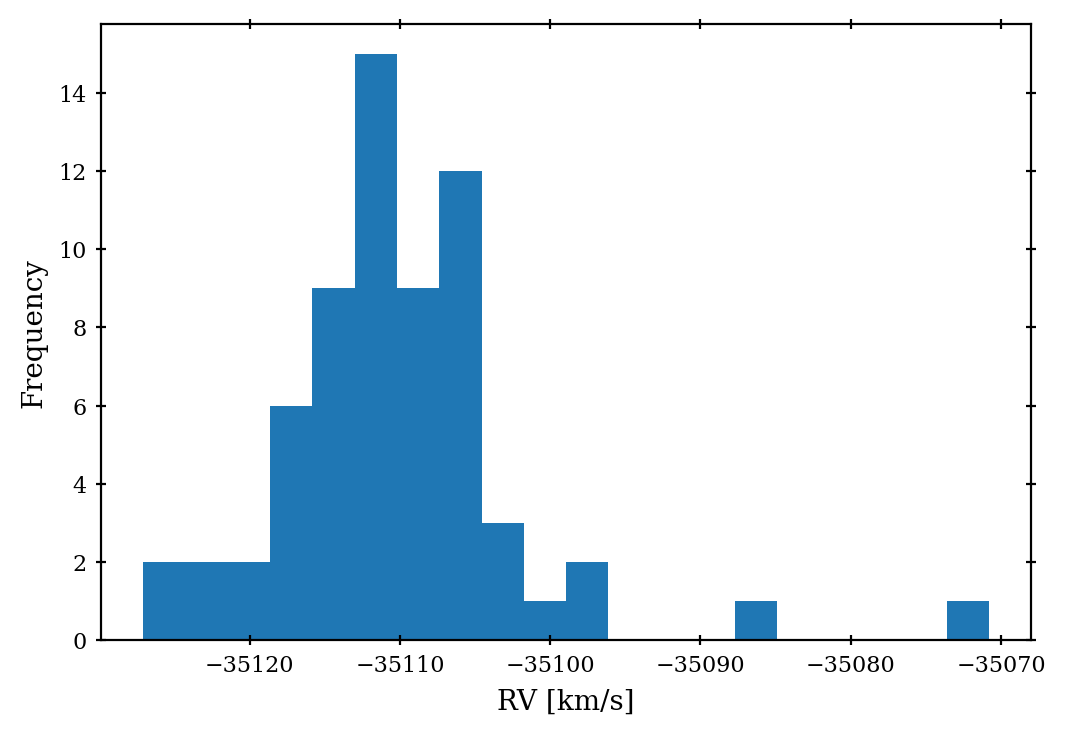

In [8]:
# histograma
spirou.vrad.plot(kind='hist', bins=20)
plt.xlabel('RV [km/s]')

<Axes: >

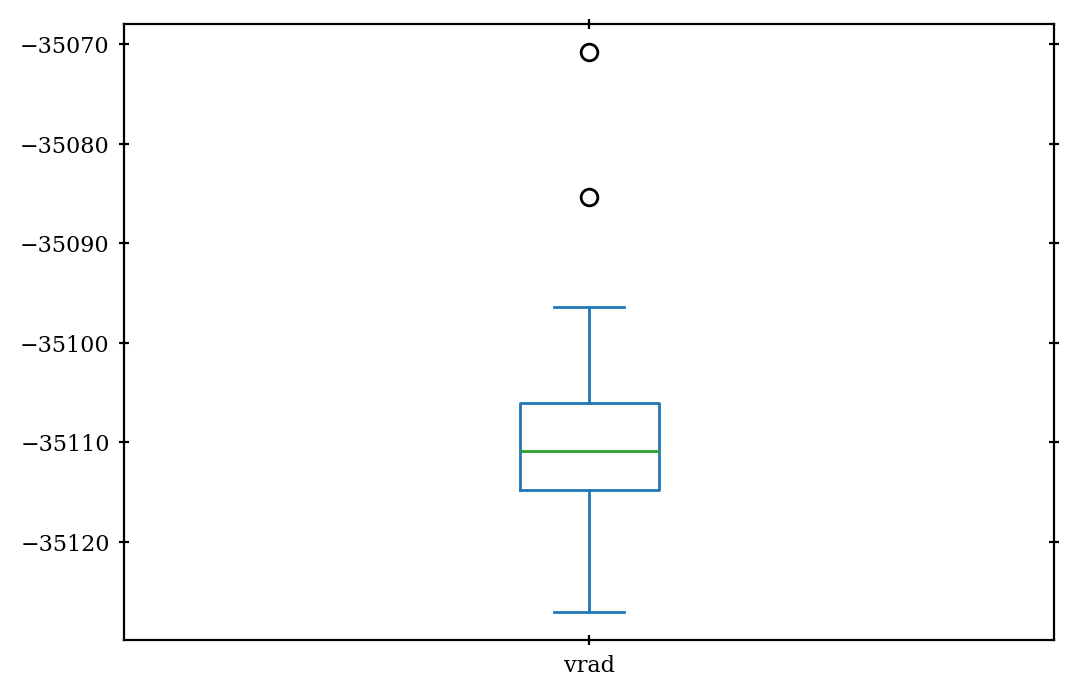

In [9]:
# boxplot
spirou.vrad.plot(kind='box')

In [10]:
# detect outliers using iqr
q1 = spirou.vrad.quantile(0.25)
q3 = spirou.vrad.quantile(0.75)
iqr = q3 - q1
mask = (spirou.vrad < (q1 - 1.5 * iqr)) | (spirou.vrad > (q3 + 1.5 * iqr))

# filter outliers
spirou = spirou[~mask]

# substract the mean of the radial velocity
spirou['vrad'] = spirou['vrad'] - spirou['vrad'].mean()

<Axes: >

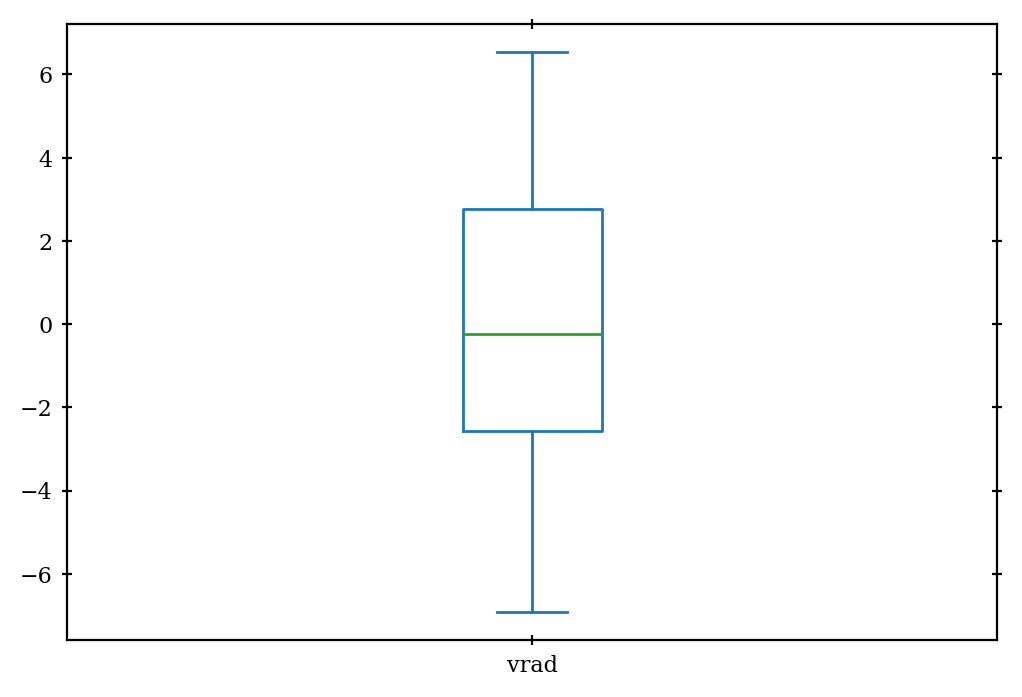

In [11]:
# after filtering
carmenes.vrad.plot(kind='box')

### Plot RVs

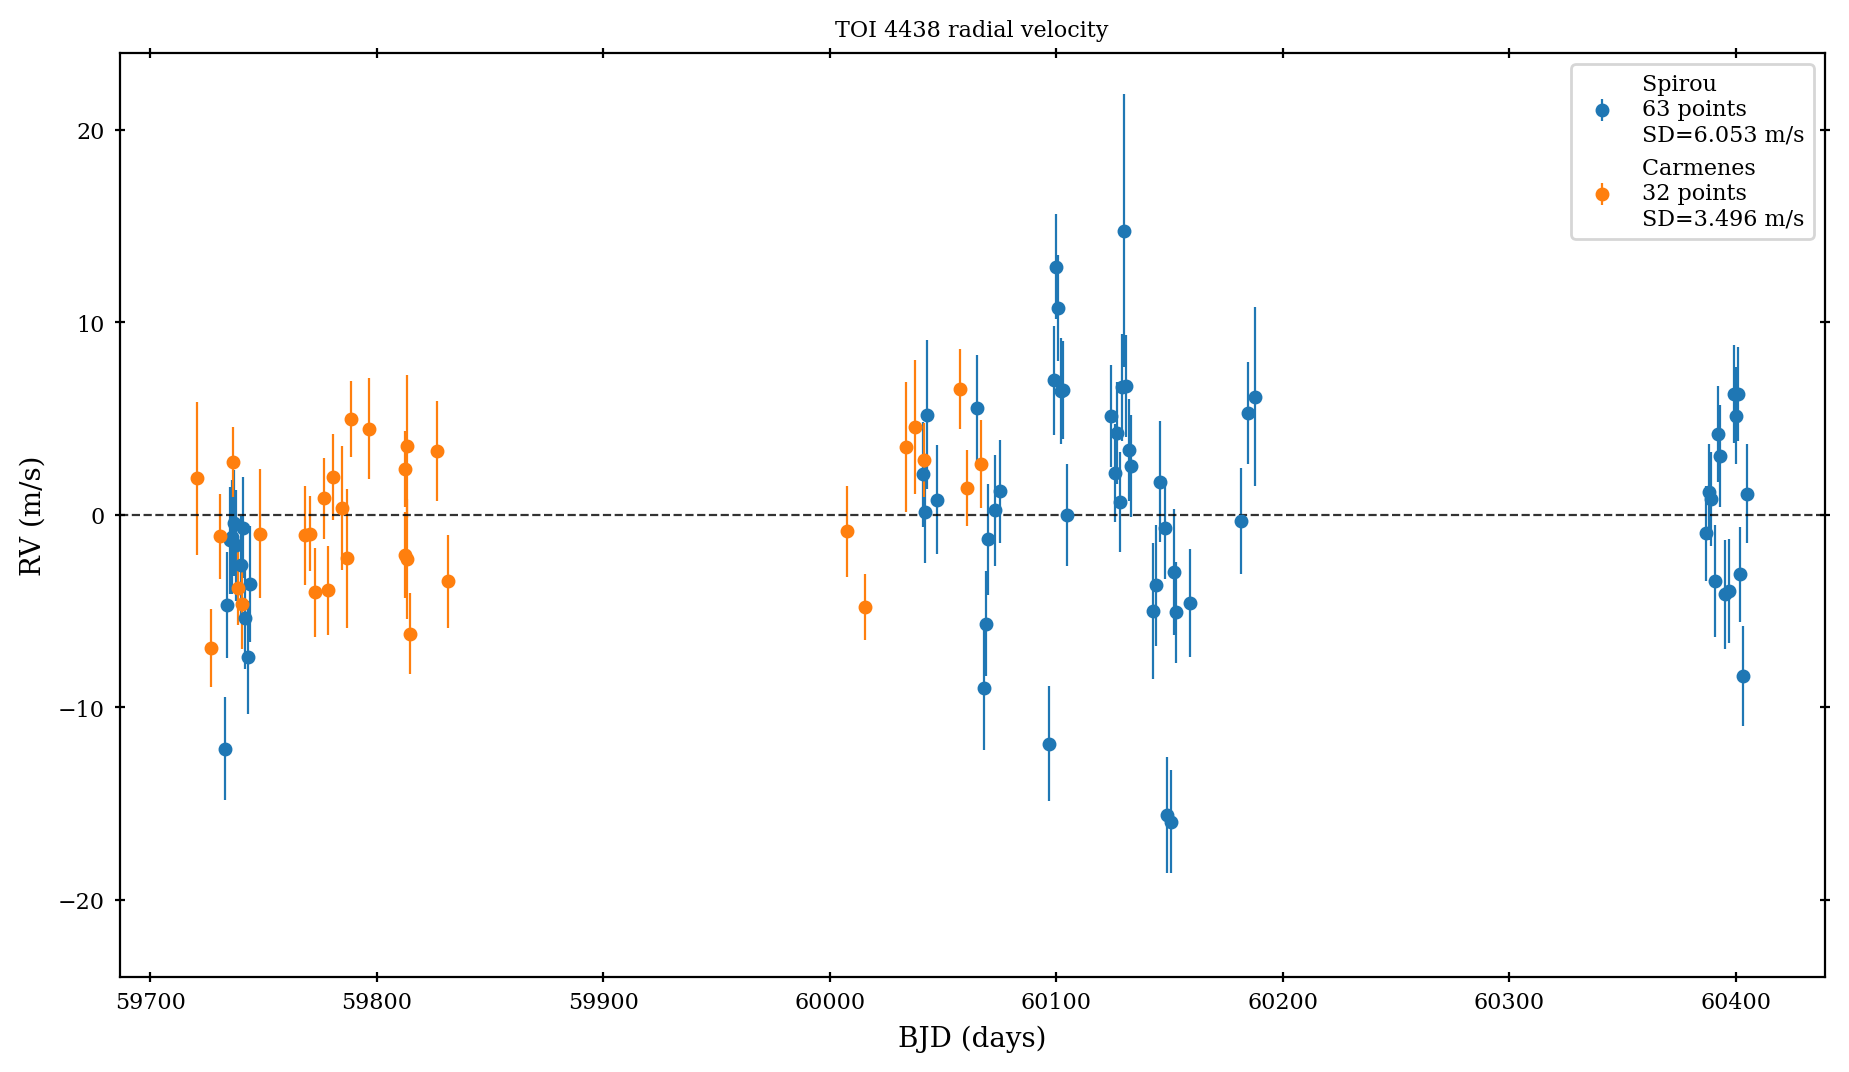

In [12]:
fig, ax = plt.subplots(figsize=(11, 6))

ax.errorbar(spirou['rjd'], spirou['vrad'], yerr=spirou['svrad'], fmt='o', label=f'Spirou \n{len(spirou)} points\nSD={np.round(np.std(spirou.vrad),3)} m/s', markersize=4, elinewidth=0.8, color='C0')
ax.errorbar(carmenes['rjd'], carmenes['vrad'], yerr=carmenes['svrad'], fmt='o', label=f'Carmenes \n{len(carmenes)} points\nSD={np.round(np.std(carmenes.vrad),3)} m/s', markersize=4, elinewidth=0.8, color='C1')
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.8)
ax.legend()
ax.set_title(f'{star_name} radial velocity')
ax.set_ylim(-24, 24)
ax.set_xlabel('BJD (days)')
ax.set_ylabel('RV (m/s)')
plt.show()

### Define RV variables

In [13]:
# prepare the data for the model
x_rv = np.concatenate((spirou['rjd'], carmenes['rjd']))
y_rv = np.concatenate((spirou['vrad'], carmenes['vrad']))
yerr_rv = np.concatenate((spirou['svrad'], carmenes['svrad']))
rv_inst_id = np.concatenate((np.zeros(len(spirou)), np.ones(len(carmenes))))

inds = np.argsort(x_rv)
t_rv = np.ascontiguousarray(x_rv[inds], dtype=np.float64)
rv = np.ascontiguousarray(y_rv[inds], dtype=np.float64)
rv_err = np.ascontiguousarray(yerr_rv[inds], dtype=np.float64)
rv_inst_id = np.ascontiguousarray(rv_inst_id[inds], dtype=int)

num_rv_inst = len(rv_inst_names)

### GLS analysis

In [14]:
series = ['spirou rvs', 'spirou dlw',  'carmenes rvs', 'all rvs', 'window function']

lg = [ls(spirou.rjd, spirou.vrad, spirou.svrad),
      ls(spirou.rjd, spirou.d2v, spirou.sd2v),
      ls(carmenes.rjd, carmenes.vrad, carmenes.svrad),
      ls(t_rv, rv, rv_err),
      ls(spirou.rjd, np.ones(len(spirou.rjd)), fit_mean=False, center_data=False)]

min_freq = 0.001
max_freq = 10
sppk = 5
probabilities = [0.1, 0.05, 0.01]

freq = {}
power = {}
fap = {}

for n, name in enumerate(series):
    freq[name], power[name] = lg[n].autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=sppk)
    if name != 'window function':
        fap[name] = lg[n].false_alarm_level(probabilities)

Text(0, 0.5, 'Power')

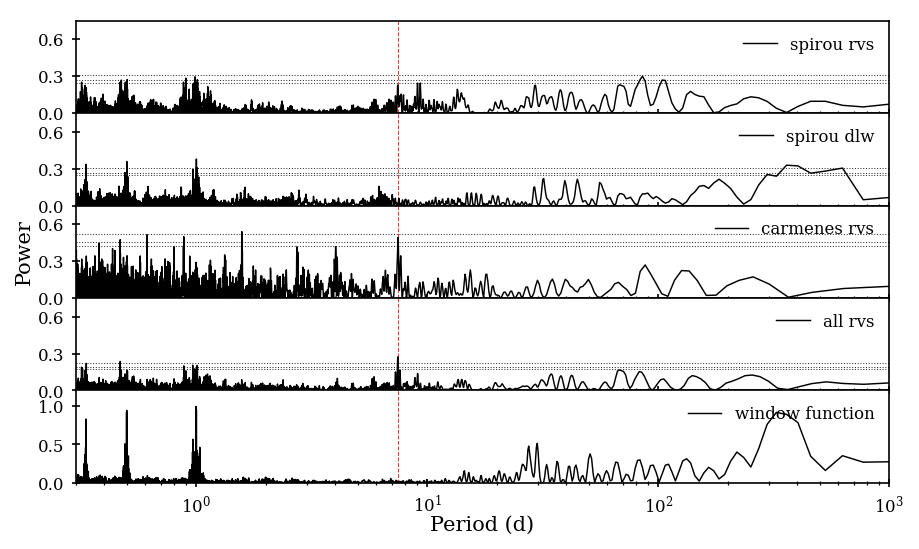

In [15]:
# plot the periodograms
fig, ax = plt.subplots(len(series), 1, sharex=True, figsize=(7,4), dpi=150)
#fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

for i, name in enumerate(series):
    ax[i].axvline(x=period_tess.nominal_value, color='r', linestyle='--', linewidth=0.5, alpha=0.8)
    ax[i].plot(1/freq[series[i]], power[series[i]], color='k', linewidth=0.7, label=name)
    ax[i].set_ylabel(series[i])
    ax[i].set_ylim(0, 0.75)
    ax[i].set_xlim(0.3, 1000)
    ax[i].set_xscale('log')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].legend(frameon=False, markerscale=0, loc='upper right')
    ax[i].set_yticks([0.0, 0.3, 0.6])
    ax[i].tick_params(which='both', top=False, right=False)
    if name == "window function":
        ax[i].set_ylim(0, 1.2)
        ax[i].set_yticks([0.0, 0.5, 1.0])
    else:
        ax[i].axhline(y=fap[name][0], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                  , label=f'FAP {probabilities[0]*100}%', zorder=0)
        ax[i].axhline(y=fap[name][1], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[1]*100}%', zorder=0)
        ax[i].axhline(y=fap[name][2], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[2]*100}%', zorder=0)
    
# add a big axis, hide frame
bigax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bigax.set_xlabel("Period (d)", labelpad=2)
bigax.set_ylabel("Power", labelpad=2)

## Read LCs

In [16]:
#exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480

In [17]:
tpf_search = lk.search_targetpixelfile('TIC 22233480')
tpf_search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 40,2021,SPOC,120,22233480,0.0
1,TESS Sector 52,2022,SPOC,120,22233480,0.0
2,TESS Sector 53,2022,SPOC,120,22233480,0.0
3,TESS Sector 79,2024,SPOC,20,22233480,0.0
4,TESS Sector 80,2024,SPOC,20,22233480,0.0
5,TESS Sector 79,2024,SPOC,120,22233480,0.0
6,TESS Sector 80,2024,SPOC,120,22233480,0.0
7,TESS Sector 40,2021,TESS-SPOC,600,22233480,0.0
8,TESS Sector 52,2022,TESS-SPOC,600,22233480,0.0


In [18]:
search = lk.search_lightcurve('TIC 22233480')
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 40,2021,SPOC,120,22233480,0.0
1,TESS Sector 52,2022,SPOC,120,22233480,0.0
2,TESS Sector 53,2022,SPOC,120,22233480,0.0
3,TESS Sector 79,2024,SPOC,20,22233480,0.0
4,TESS Sector 80,2024,SPOC,20,22233480,0.0
5,TESS Sector 79,2024,SPOC,120,22233480,0.0
6,TESS Sector 80,2024,SPOC,120,22233480,0.0
7,TESS Sector 40,2021,TESS-SPOC,600,22233480,0.0
8,TESS Sector 52,2022,TESS-SPOC,600,22233480,0.0


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

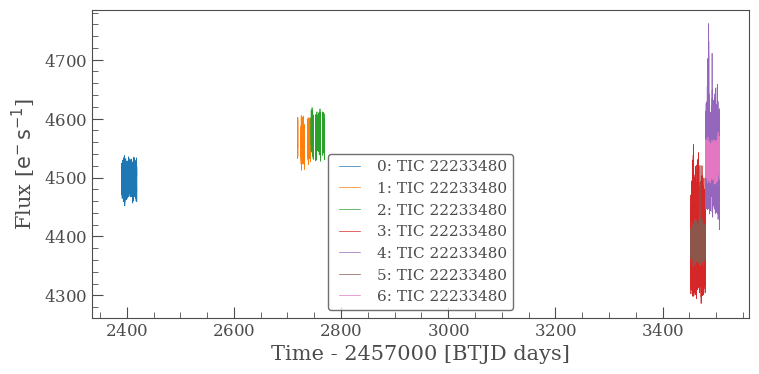

In [19]:
search[search.author == 'SPOC'].download_all().plot()

In [20]:
# save the lightcurves
lc_short_file = lk.search_lightcurve('TIC 22233480', author='SPOC', exptime=120, sector=[40, 52, 53]).download_all(flux_column="pdcsap_flux")
lc_79_fast_file = lk.search_lightcurve('TIC 22233480', author='SPOC', sector=[79], exptime=20).download_all(flux_column="pdcsap_flux")
lc_79_short_file = lk.search_lightcurve('TIC 22233480', author='SPOC', sector=[79], exptime=120).download_all(flux_column="pdcsap_flux")
lc_short_all_file = lk.search_lightcurve('TIC 22233480', author='SPOC', exptime=120, sector=[40, 52, 53, 79]).download_all(flux_column="pdcsap_flux")

In [21]:
lc_short_all = lc_short_all_file.stitch().remove_nans().normalize().remove_outliers()
lc_short = lc_short_file.stitch().remove_nans().normalize().remove_outliers()
lc_79_fast = lc_79_fast_file.stitch().remove_nans().normalize().remove_outliers()
lc_79_fast_bin = lc_79_fast.bin(time_bin_size=120*u.s.to(u.day)).remove_nans()
lc_79_short = lc_79_short_file.stitch().remove_nans().normalize().remove_outliers()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

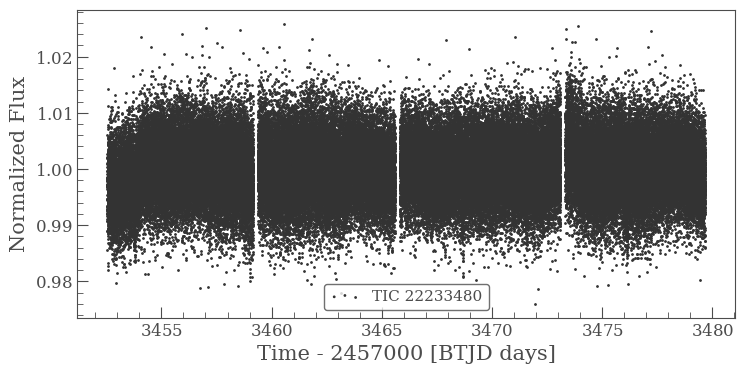

In [22]:
# plot sector 79 fast cadence
lc_79_fast.scatter()

(-0.5, 0.5)

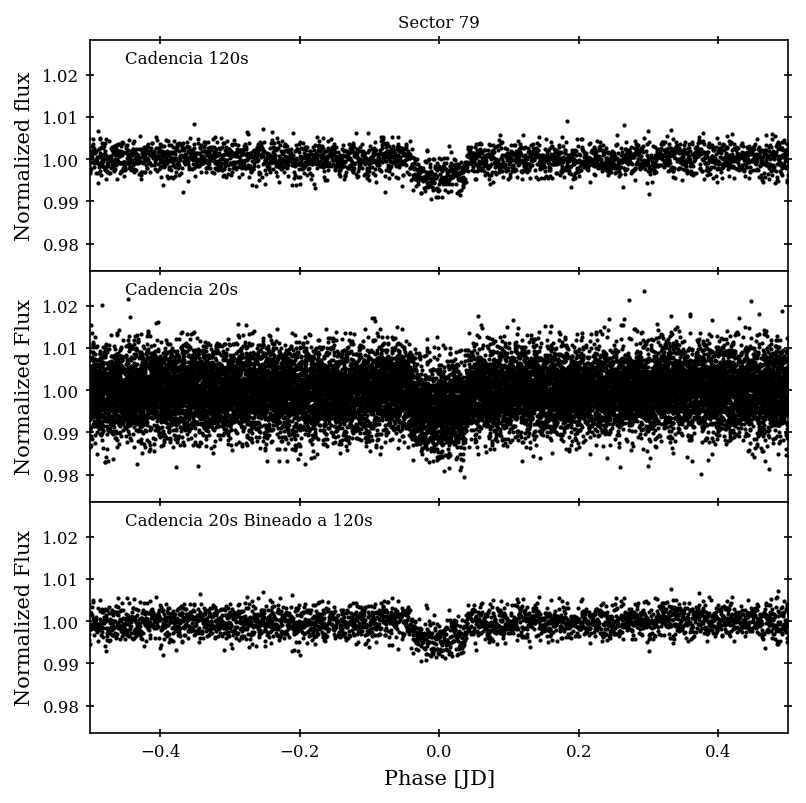

In [23]:
# sector 79
fig, ax = plt.subplots(3, 1, figsize=(6,6), dpi=150, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
lc_79_short.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[0], c='k', label='')
lc_79_fast.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[1], c='k', label='')
lc_79_fast_bin.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[2], c='k', label='')
ax[0].text(0.05, 0.9, 'Cadencia 120s', transform=ax[0].transAxes)
ax[1].text(0.05, 0.9, 'Cadencia 20s', transform=ax[1].transAxes)
ax[2].text(0.05, 0.9, 'Cadencia 20s Bineado a 120s', transform=ax[2].transAxes)
ax[0].set_title('Sector 79')
ax[0].set_ylabel('Normalized flux')
ax[0].set_xlabel('Phase')
plt.xlim(-0.5, 0.5)
#plt.savefig('lc_79.png', dpi=300)

### Asteroseismology?

(0.0, 5e-08)

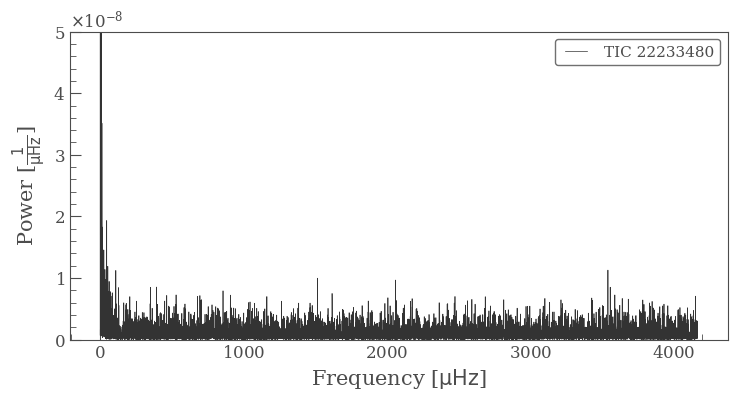

In [24]:
seism = lc_79_fast_bin.to_periodogram(normalization='psd')
ax = seism.plot()
#plt.xlim(500, 3500)
plt.ylim(0,5e-8)

### LC to use

In [25]:
# for the model, short and fast cadence are concatenated
time = np.concatenate((lc_short.time.value, lc_79_fast.time.value))
flux = np.concatenate((lc_short.flux.value, lc_79_fast.flux.value))
flux_err = np.concatenate((lc_short.flux_err.value, lc_79_fast.flux_err.value))
lc_cadence = np.concatenate((np.zeros(len(lc_short.time.value)), np.ones(len(lc_79_fast.time.value))))
inds2 = np.argsort(time)
time = np.ascontiguousarray(time[inds2], dtype=np.float64)
flux = np.ascontiguousarray(flux[inds2], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[inds2], dtype=np.float64)
lc_cadence = np.ascontiguousarray(lc_cadence[inds2], dtype=int)
cadences = ['120s', '20s']
num_lc_cadence = len(cadences)

# for faster computation, sector 79 binned to 120s
# only sector 79
time_fast = lc_79_fast_bin.time.value
flux_fast = lc_79_fast_bin.flux.value
flux_err_fast = lc_79_fast_bin.flux_err.value

# all sectors with 120s cadence, 79 binned from 20s
time_short = np.ascontiguousarray(np.concatenate((lc_short.time.value, lc_79_fast_bin.time.value)), dtype=np.float64)
flux_short = np.ascontiguousarray(np.concatenate((lc_short.flux.value, lc_79_fast_bin.flux.value)), dtype=np.float64)
flux_err_short = np.ascontiguousarray(np.concatenate((lc_short.flux_err.value, lc_79_fast_bin.flux_err.value)), dtype=np.float64)

# all sectors binned to 5 minutes for faster computation, 79 from 20s
# bin to 5 minutes
lc_short_5min = lc_short.bin(time_bin_size=5*u.min.to(u.day)).remove_nans()
lc_79_fast_5min = lc_79_fast.bin(time_bin_size=5*u.min.to(u.day)).remove_nans()
time5 = np.concatenate((lc_short_5min.time.value, lc_79_fast_5min.time.value))
flux5 = np.concatenate((lc_short_5min.flux.value, lc_79_fast_5min.flux.value))
flux_err5 = np.concatenate((lc_short_5min.flux_err.value, lc_79_fast_5min.flux_err.value))
inds5 = np.argsort(time5)
time_5min = np.ascontiguousarray(time5[inds5], dtype=np.float64)
flux_5min = np.ascontiguousarray(flux5[inds5], dtype=np.float64)
flux_err_5min = np.ascontiguousarray(flux_err5[inds5], dtype=np.float64)

# all sectors with 120s cadence
time_short_all = np.ascontiguousarray(lc_short_all.time.value, dtype=np.float64)
flux_short_all = np.ascontiguousarray(lc_short_all.flux.value, dtype=np.float64)
flux_err_short_all = np.ascontiguousarray(lc_short_all.flux_err.value, dtype=np.float64)

# get the exptimes
with fits.open(lc_short_file[0].filename) as hdu:
    hdr = hdu[1].header
with fits.open(lc_79_fast_file[0].filename) as hdu:
    hdr_79 = hdu[1].header

texp_short = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp_short /= 60.0 * 60.0 * 24.0
texp_79 = hdr_79["FRAMETIM"] * hdr_79["NUM_FRM"]
texp_79 /= 60.0 * 60.0 * 24.0
texp_300 = 5.0 / 60.0 / 24.0

ref_time = np.min(time_short)

### TLS analysis

In [26]:
from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )

In [27]:
# lets recover first the planet detected by TESS 
tls_time, tls_flux, tls_flux_err = cleaned_array(time_short, flux_short, flux_err_short)

# catalog_info: ab, mass, mass_min, mass_max, radius, radius_min, radius_max
info = catalog_info(TIC_ID=TIC_ID) # to put priors on search
tls = transitleastsquares(tls_time, tls_flux, tls_flux_err)
results = tls.power(R_star=float(info[4]), R_star_min=info[4]-info[5], R_star_max=info[4]+info[6],
                   M_star=float(info[1]), M_star_min=info[1]-info[2], M_star_max=info[1]+info[3],
                   u=list(info[0]), period_min=period_tess.nominal_value-0.1, period_max=period_tess.nominal_value+0.1)

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 29 durations
Searching 58347 data points, 1129 periods from 7.346 to 7.546 days
Using all 12 CPU threads


100%|██████████| 1129/1129 periods | 00:24<00:00


Searching for best T0 for period 7.44621 days


100%|██████████| 7012/7012 [00:14<00:00, 483.26it/s]
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/transitleastsquares/main.py:411: UserWarning: 132 of 146 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [28]:
print(results.period, results.T0, results.duration, results.depth, results.SDE)

7.446209203686082 2396.4162284565173 0.007924848795517376 0.995857380778413 15.3696948227958


(0.0, 50.0)

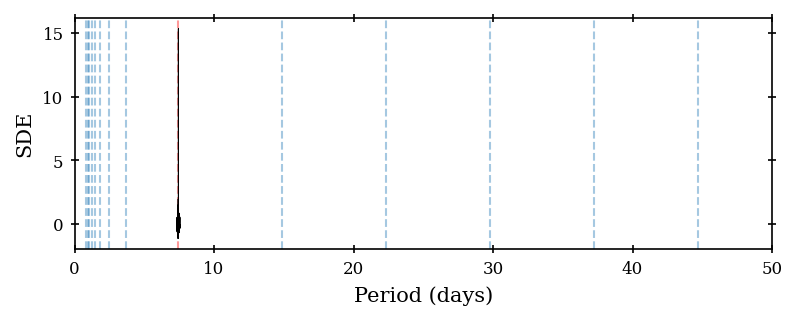

In [29]:
fig, ax = plt.subplots(figsize=(6,2), dpi=150)
plt.xlim(np.min(results.periods), np.max(results.periods))
ax.axvline(results.period, alpha=0.4, lw=1, linestyle="dashed", color='red')
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods))
plt.xlim(0, 50)
#plt.ylim(0, 100)

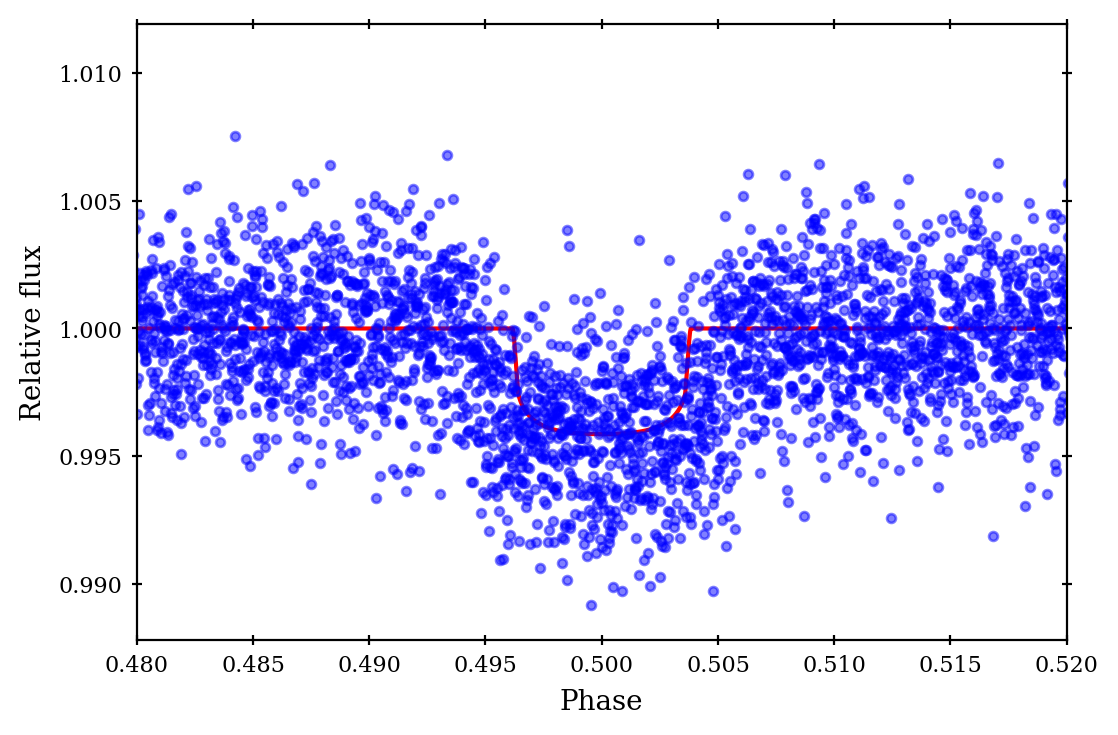

In [30]:
# results phase folded
plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.48, 0.52)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

In [31]:
results.duration*10

0.07924848795517375

In [32]:
duration_tess/24

0.08347140734040416+/-0.006621239583333332

(2418.0, 2420.0)

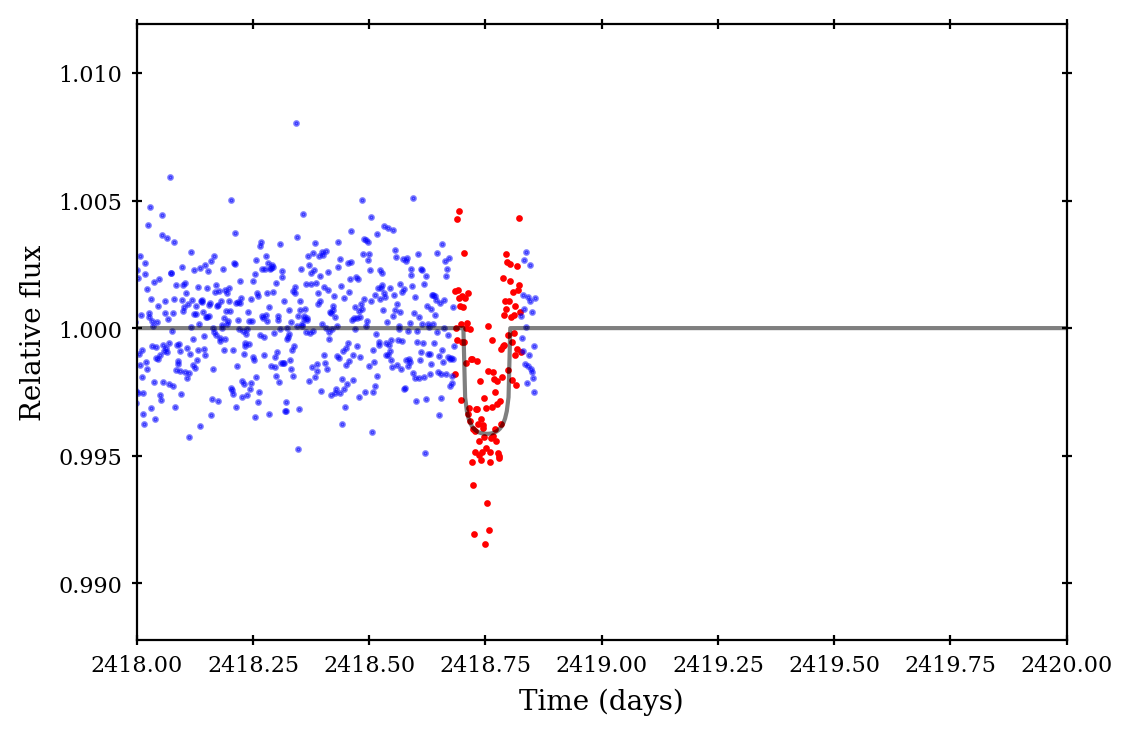

In [33]:
# complete light curve
plt.figure()
in_transit = transit_mask(tls_time, results.period, results.duration*18, results.T0)
plt.scatter(tls_time[in_transit], tls_flux[in_transit], color='red', s=2, zorder=0)
plt.scatter(tls_time[~in_transit], tls_flux[~in_transit], color='blue', alpha=0.5, s=2, zorder=0)
plt.plot(results.model_lightcurve_time, results.model_lightcurve_model, alpha=0.5, color='k', zorder=1)
plt.xlim(tls_time.min(), tls_time.max())
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');
plt.xlim(2418,2420)

In [34]:
# # search for second planet
# tls_time_2 = tls_time[~in_transit]
# tls_flux_2 = tls_flux[~in_transit]
# tls_flux_err_2 = tls_flux_err[~in_transit]

# tls_2 = transitleastsquares(tls_time_2, tls_flux_2, tls_flux_err_2)
# results2 = tls_2.power(R_star=float(info[4]), R_star_min=info[4]-info[5], R_star_max=info[4]+info[6],
#                                                 M_star=float(info[1]), M_star_min=info[1]-info[2], M_star_max=info[1]+info[3],
#                                                 period_min=0.5,
#                                                 period_max=(tls_time_2.max()-tls_time_2.min())/2,
#                                                 u=list(info[0]))

In [35]:
# print(results2.period, results2.T0, results2.duration, results2.depth, results2.SDE)

In [36]:
# fig, ax = plt.subplots(figsize=(6,2), dpi=150)
# plt.xlim(np.min(results2.periods), np.max(results2.periods))
# ax.axvline(results2.period, alpha=0.4, lw=1, linestyle="dashed", color='red')
# for n in range(2, 10):
#     ax.axvline(n*results2.period, alpha=0.4, lw=1, linestyle="dashed")
#     ax.axvline(results2.period / n, alpha=0.4, lw=1, linestyle="dashed")
# plt.ylabel(r'SDE')
# plt.xlabel('Period (days)')
# plt.plot(results2.periods, results2.power, color='black', lw=0.5)
# #plt.xlim(0, max(results2.periods))
# plt.xlim(0, 50)
# plt.ylim(-1, 10)

In [37]:
# # results phase folded
# plt.figure()
# plt.plot(results2.model_folded_phase, results2.model_folded_model, color='red')
# plt.scatter(results2.folded_phase, results2.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
# plt.xlim(0.48, 0.52)
# plt.xlabel('Phase')
# plt.ylabel('Relative flux');

In [38]:
# # complete light curve
# plt.figure()
# in_transit2 = transit_mask(tls_time_2, results2.period, 1.5*results2.duration, results2.T0)
# plt.scatter(tls_time_2[in_transit2], tls_flux_2[in_transit2], color='red', s=2, zorder=0)
# plt.scatter(tls_time_2[~in_transit2], tls_flux_2[~in_transit2], color='blue', alpha=0.5, s=2, zorder=0)
# plt.plot(results2.model_lightcurve_time, results2.model_lightcurve_model, alpha=0.5, color='k', zorder=1)
# plt.xlim(tls_time_2.min(), tls_time_2.max())
# plt.xlabel('Time (days)')
# plt.ylabel('Relative flux');
# plt.xlim(2750,2800)

### GLS analysis

Text(0.5, 1.0, 'GLS periodogram of TESS sectors (out of transit)')

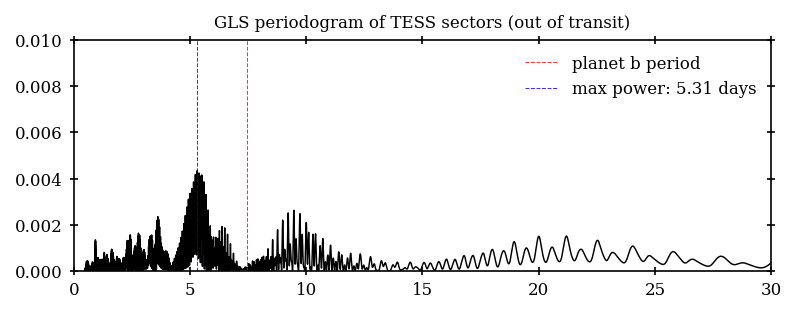

In [39]:
# first remove in-transit points
in_transit3 = transit_mask(time_short_all, results.period, 15*results.duration, results.T0)
lslc = ls(time_short_all[~in_transit3], flux_short_all[~in_transit3], flux_err_short_all[~in_transit3])

lc_freq, lc_power = lslc.autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=50)

# # plot the periodogram
fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=150)
ax.plot(1/lc_freq, lc_power, color='k', linewidth=0.7)
ax.set_xlim(0,30)
ax.set_ylim(0, 0.01)
ax.axvline(period_tess.nominal_value, color='r', linestyle='--', linewidth=0.5, alpha=0.8, label='planet b period')
ax.axvline(1/lc_freq[np.argmax(lc_power)], color='b', linestyle='--', linewidth=0.5, alpha=0.8, 
           label='max power: '+str(np.round(1/lc_freq[np.argmax(lc_power)],2))+' days')
ax.legend(frameon=False, markerscale=0)
ax.set_title('GLS periodogram of TESS sectors (out of transit)')

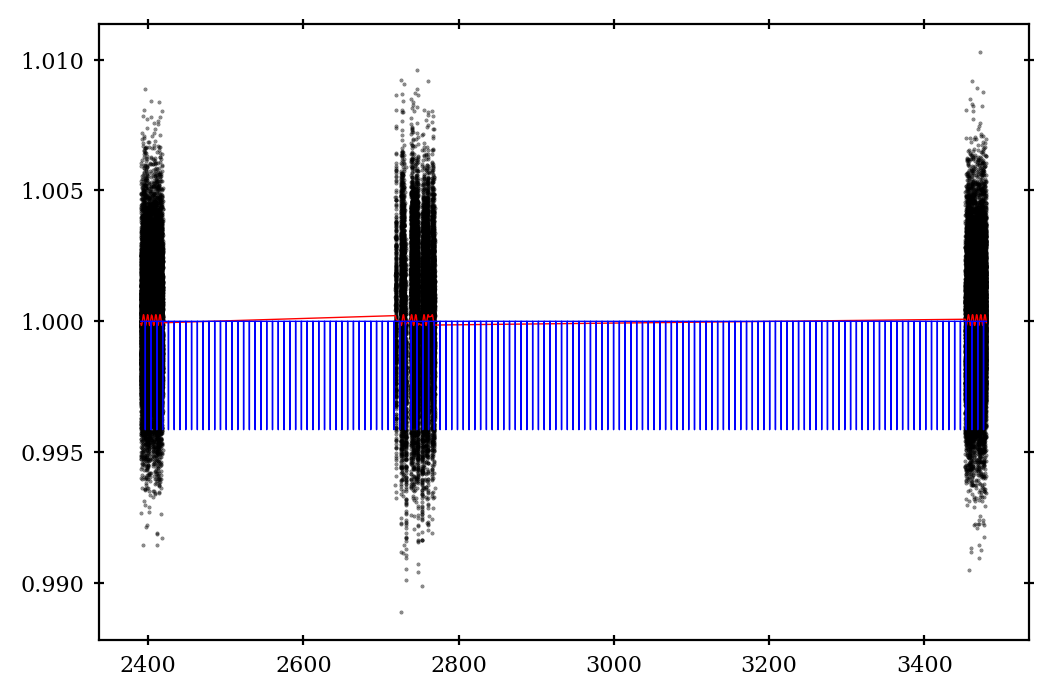

In [40]:
y_fit = lslc.model(time_short_all[~in_transit3], lc_freq[np.argmax(lc_power)])
plt.plot(time_short_all[~in_transit3], y_fit, color='r', linewidth=0.5)
plt.scatter(time_short_all[~in_transit3], flux_short_all[~in_transit3], color='k', s=0.2, alpha=0.5)
plt.plot(results.model_lightcurve_time, results.model_lightcurve_model, color='b', linewidth=0.5)
#plt.xlim(3452, 3477)
#plt.xlim(2735, 2750)

In [41]:
# compare rms of residuals and rms of data
rms_data = np.std(flux_short_all[~in_transit3])
rms_res = np.std(flux_short_all[~in_transit3] - y_fit)
print(rms_data*1e3, rms_res*1e3)

2.2771850090688233 2.2717604426410962


## Modelo Global

#### Model variables

In [42]:
def get_xy(time):
    # parametros
    # ----------
    # time: '120', '300' (int)
    # devuelve
    # ----------
    # x, y, yerr, texp (en días y ppt)
    if time == 120:
        t = time_short
        flux = flux_short
        flux_err = flux_err_short
        texp = texp_short
    elif time == 300:
        t = time_5min
        flux = flux_5min
        flux_err = flux_err_5min
        texp = texp_300

    x = np.ascontiguousarray(t - ref_time, dtype=np.float64)
    y = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
    yerr = np.ascontiguousarray(1e3 * flux_err, dtype=np.float64) 
    return x, y, yerr, texp

In [43]:
# rvs: t_rv, rv, rv_err, rv_inst_id

# rvs para modelo
x_rv, y_rv, yerr_rv = t_rv - ref_time - 57000, rv, rv_err

# lc para modelo
x, y, yerr, texp = get_xy(300)

### GP in LC and RV

In [44]:
# # version with GP in RV and LC 
# # I should CHECK THE MEAN OFFSET OF THE MODEL PER INSTRUMENT, IT'S NOT IMPLEMENTED HERE

# phase_lc = np.linspace(-0.3, 0.3, 100)
# t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1500)

# with pm.Model() as model:
#     # Parameters for the stellar properties
#     lc_mean = pm.Normal("lc_mean", mu=0.0, sigma=1.0)
#     u_star = xo.QuadLimbDark("u_star")
#     star = xo.LimbDarkLightCurve(u_star)

#     # Stellar parameters from TESS
#     mstar = pm.TruncatedNormal("mstar", mu=stmass_tess.n, sigma=stmass_tess.s, lower=0.0, upper=1.0)
#     rstar = pm.TruncatedNormal("rstar", mu=strad_tess.n, sigma=strad_tess.s, lower=0.0, upper=1.0)

#     # Orbital parameters for the planet
#     t0 = pm.Normal("t0", mu=results.T0-ref_time, sigma=1.0)
#     logP = pm.Normal("logP", mu=np.log(results.period), sigma=results.period_uncertainty/results.period)
#     P = pm.Deterministic("P", pt.exp(logP))
#     K = pm.Uniform("K", lower=0, upper=10)

#     # Fit in terms of ror
#     log_ror = pm.Normal("log_ror", mu=0.5*np.log((1-results.depth)), sigma=1)
#     ror = pm.Deterministic("ror", pt.exp(log_ror))
#     r_pl = pm.Deterministic("r_pl", ror * rstar)
#     b = xo.ImpactParameter('b', ror)
 
#     h, k = xo.unit_disk("h", "k", initval=np.array([0.01, 0.01]))
#     ecc = pm.Deterministic("e", h**2 + k**2)
#     omega = pm.Deterministic("w", pt.arctan2(k, h))

#     # derived parameters
#     m_pl = pm.Deterministic('m_pl', K*pt.sqrt(1-ecc**2)*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
#     density_pl = pm.Deterministic('density_pl', m_pl*u.kg.to(u.g)/(4/3*np.pi*(r_pl*u.R_sun.to(u.cm))**3))    
#     a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))
#     teq = pm.Deterministic('teq', pub_teff.n*(rstar*u.R_sun.to(u.au)/a)**(1/2)*(1/4)**(1/4))
   
#     # LC jitter & GP parameters
#     log_sigma_lc = pm.Normal("log_sigma_lc", mu=np.log(np.std(y)), sigma=10)
#     log_rho_gp = pm.Normal("log_rho_gp", mu=0, sigma=10)
#     log_sigma_gp = pm.Normal("log_sigma_gp", mu=np.log(np.std(y)), sigma=10)

#     # RV noise & GP parameters
#     log_sigma_gp_rv = pm.Normal("log_sigma_gp_rv", mu=np.log(np.std(y_rv)), sigma=10)
#     log_rho_gp_rv = pm.Normal("log_rho_gp_rv", mu=np.log(50), sigma=50)
#     #log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.std(y_rv)), sigma=10)

#     # Orbit model
#     orbit = xo.orbits.KeplerianOrbit(
#             r_star=rstar,
#             m_star=mstar,
#             period=P,
#             t0=t0,
#             b=b,
#             ecc=ecc,
#             omega=omega,
#         )
    
#     # Compute the model light curve
#     light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x, texp=texp_short)* 1e3)
#     light_curve = pm.math.sum(light_curves, axis=-1) + lc_mean

#     # GP model for the light curve
#     kernel = terms.SHOTerm(
#             sigma=pt.exp(log_sigma_gp),
#             rho=pt.exp(log_rho_gp),
#             Q=1 / np.sqrt(2),)
    
#     gp_lc = GaussianProcess(kernel, t=x, mean=light_curve, yerr=pt.exp(log_sigma_lc))
#     gp_lc.marginal("obs_lc", observed=y)

#     # Compute and save the phased light curve models
#     pm.Deterministic("lc_pred", 1e3*star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp_short)[..., 0],)
#     pm.Deterministic("gp_lc_pred", gp_lc.predict(y, include_mean=False))

#     # RVs
#     # Per instrument parameters
#     sigmas = pm.HalfNormal("sigmas", sigma=10, shape=len(rv_inst_names))

#     # Compute the RV offset and jitter for each data point depending on its instrument
#     diag = pt.zeros(len(x_rv))
#     for i in range(len(rv_inst_names)):
#         diag += (yerr_rv**2 + sigmas[i] ** 2) * (rv_inst_id == i)
#     pm.Deterministic("rv_mean", rv_mean)
#     pm.Deterministic("diag", diag)

#     def get_rv_model(x, name=""):
#         vrad = orbit.get_radial_velocity(x, K=K)
#         pm.Deterministic("vrad" + name, vrad)
#         return pm.Deterministic("rv_model" + name, vrad)
    
#     rv_model = get_rv_model(x_rv)
#     get_rv_model(t_rv, "_pred")

#     kernelrv = terms.SHOTerm(
#         sigma=pt.exp(log_sigma_gp_rv), 
#         rho=pt.exp(log_rho_gp_rv), 
#         Q=1.0 / 3)
    
#     gp_rv = GaussianProcess(kernelrv, t=x_rv, mean=rv_model, diag=diag)
#     gp_rv.marginal("obs_rv", observed=y_rv)
#     pm.Deterministic("gp_rv_pred", gp_rv.predict(y_rv, include_mean=True))

#     map_params = pm.find_MAP()
#     map_soln = pmx.optimize(start=map_params)

#     extras = dict(zip(["light_curves"], pmx.eval_in_model(
#             [light_curves], map_soln)))

#### LC map plot

In [45]:
# fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

# lc_mod = map_soln["light_curves"][:, 0] + map_soln["lc_mean"] # lc + mean
# gp_only = map_soln["gp_lc_pred"] # gp model (on top of lc + mean)

# # first plot the gp model
# ax = axes[0]
# ax.plot(x, y, "k", label="data")
# ax.plot(x, gp_only, color="C2", label="gp model")
# ax.legend(fontsize=10)
# ax.set_ylabel("relative flux [ppt]")

# # then detrend data for gp model and plot the lc model
# ax = axes[1]
# ax.plot(x, y - gp_only, "k", label="de-trended data")
# ax.plot(x, lc_mod, label="LC - planet {0}".format(b))
# ax.legend(fontsize=10, loc=3)
# ax.set_ylabel("de-trended flux [ppt]")

# # residuals of gp + lc model
# ax = axes[2]
# ax.plot(x, y - lc_mod - gp_only, "k")
# ax.axhline(0, color="#aaaaaa", lw=1)
# ax.set_ylabel("residuals [ppt]")
# ax.set_xlim(x.min(), x.max())
# ax.set_xlabel("time [days]")
# plt.xlim(345, 360)

# #plt.savefig('toi4438_lc.png', dpi=300)

#### RV map plot

In [46]:
# fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

# lc_mod = map_soln["light_curves"][:, 0] + map_soln["lc_mean"] # lc + mean
# gp_only = map_soln["gp_lc_pred"] # gp model (on top of lc + mean)

# # first plot the gp model
# ax = axes[0]
# ax.plot(x, y, "k", label="data")
# ax.plot(x, gp_only, color="C2", label="gp model")
# ax.legend(fontsize=10)
# ax.set_ylabel("relative flux [ppt]")

# # then detrend data for gp model and plot the lc model
# ax = axes[1]
# ax.plot(x, y - gp_only, "k", label="de-trended data")
# ax.plot(x, lc_mod, label="LC - planet {0}".format(b))
# ax.legend(fontsize=10, loc=3)
# ax.set_ylabel("de-trended flux [ppt]")

# # residuals of gp + lc model
# ax = axes[2]
# ax.plot(x, y - lc_mod - gp_only, "k")
# ax.axhline(0, color="#aaaaaa", lw=1)
# ax.set_ylabel("residuals [ppt]")
# ax.set_xlim(x.min(), x.max())
# ax.set_xlabel("time [days]")
# plt.xlim(345, 360)

# #plt.savefig('toi4438_lc.png', dpi=300)

### GP in LC, constant background in RV

In [53]:
# version with GP in RV and LC 
phase_lc = np.linspace(-0.3, 0.3, 100)
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1500)

with pm.Model() as model:
    # Parameters for the stellar properties
    lc_mean = pm.Normal("lc_mean", mu=0.0, sigma=1.0)
    u_star = xo.QuadLimbDark("u_star")
    star = xo.LimbDarkLightCurve(u_star)

    # Stellar parameters from TESS
    mstar = pm.TruncatedNormal("mstar", mu=stmass_tess.n, sigma=stmass_tess.s, lower=0.0, upper=1.0)
    rstar = pm.TruncatedNormal("rstar", mu=strad_tess.n, sigma=strad_tess.s, lower=0.0, upper=1.0)

    # Orbital parameters for the planet
    t0 = pm.Normal("t0", mu=results.T0-ref_time, sigma=1.0)
    logP = pm.Normal("logP", mu=np.log(results.period), sigma=results.period_uncertainty/results.period)
    P = pm.Deterministic("P", pt.exp(logP))
    K = pm.Uniform("K", lower=0, upper=10)

    # Fit in terms of ror
    log_ror = pm.Normal("log_ror", mu=0.5*np.log((1-results.depth)), sigma=1)
    ror = pm.Deterministic("ror", pt.exp(log_ror))
    r_pl = pm.Deterministic("r_pl", ror * rstar)
    b = xo.ImpactParameter('b', ror)
 
    h, k = xo.unit_disk("h", "k", initval=np.array([0.01, 0.01]))
    ecc = pm.Deterministic("e", h**2 + k**2)
    omega = pm.Deterministic("w", pt.arctan2(k, h))

    # derived parameters
    m_pl = pm.Deterministic('m_pl', K*pt.sqrt(1-ecc**2)*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
    density_pl = pm.Deterministic('density_pl', m_pl*u.kg.to(u.g)/(4/3*np.pi*(r_pl*u.R_sun.to(u.cm))**3))    
    a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))
    teq = pm.Deterministic('teq', pub_teff.n*(rstar*u.R_sun.to(u.au)/a)**(1/2)*(1/4)**(1/4))
   
    # LC jitter & GP parameters
    log_sigma_lc = pm.Normal("log_sigma_lc", mu=np.log(np.std(y)), sigma=10)
    log_rho_gp = pm.Normal("log_rho_gp", mu=0, sigma=10)
    log_sigma_gp = pm.Normal("log_sigma_gp", mu=np.log(np.std(y)), sigma=10)

    # RV noise & GP parameters
    log_sigma_gp_rv = pm.Normal("log_sigma_gp_rv", mu=np.log(np.std(y_rv)), sigma=10)
    log_rho_gp_rv = pm.Normal("log_rho_gp_rv", mu=np.log(50), sigma=50)
    #log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.std(y_rv)), sigma=10)

    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(
            r_star=rstar,
            m_star=mstar,
            period=P,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )
    
    # Compute the model light curve
    light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x, texp=texp_short)* 1e3)
    pm.Deterministic("light_curves", light_curves)
    light_curve = pm.math.sum(light_curves, axis=-1) + lc_mean

    # GP model for the light curve
    kernel = terms.SHOTerm(
            sigma=pt.exp(log_sigma_gp),
            rho=pt.exp(log_rho_gp),
            Q=1 / np.sqrt(2),)
    
    gp_lc = GaussianProcess(kernel, t=x, mean=light_curve, yerr=pt.exp(log_sigma_lc))
    gp_lc.marginal("obs_lc", observed=y)

    # Compute and save the phased light curve models
    pm.Deterministic("lc_pred", 1e3*star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp_short)[..., 0],)
    pm.Deterministic("gp_lc_pred", gp_lc.predict(y, include_mean=False))
    
    # Function for computing the full RV model
    def get_rv_model(x, name=""):
        vrad = orbit.get_radial_velocity(x, K=K)
        pm.Deterministic("vrad" + name, vrad)
        return pm.Deterministic("rv_model" + name, vrad)
    

    # Loop over the instruments
    parameters = dict()
    rv_models = dict()

    means = pm.Normal("means", mu=np.array([np.median(y_rv[rv_inst_id == i]) for i in range(len(rv_inst_names))]), sigma=5, shape=len(rv_inst_names))
    log_sigmas_rv = pm.Normal("log_sigmas_rv", mu=np.log(np.array([(np.median(yerr_rv[rv_inst_id == i])) for i in range(len(rv_inst_names))])), sigma=1)

    mean = pt.zeros(len(x_rv))
    sigma = pt.zeros(len(x_rv))
    for i in range(len(rv_inst_names)):
        mean += means[i] * (rv_inst_id == i)
        sigma += (yerr_rv**2 + pt.exp(2 * log_sigmas_rv[i]) * (rv_inst_id == i))

    pm.Deterministic("mean", mean)
    pm.Deterministic("sigma", sigma)

    # rv model
    rv_model = get_rv_model(x_rv) + mean
    get_rv_model(t_rv, "_pred")

    # the likelihood for the rvs
    err = pt.sqrt(sigma)
    pm.Normal("obs", mu=rv_model, sigma=err, observed=y_rv)
    # # Per instrument parameters
    # for i, name in enumerate(rv_inst_names):
    #     # We define the per-instrument parameters in a submodel
    #     with pm.Model(name=name, model=model):
    #         # the RV offset
    #         mean_rv = pm.Normal("rv_mean", mu=0.0, sigma=5.0)
    #         # RV jitter
    #         log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv[rv_inst_id == i])), sigma=1)
    #         parameters[name] = [mean_rv, log_sigma_rv]
    #         # rv model
    #         rv_models[name] = get_rv_model(x_rv[rv_inst_id == i], mean_rv)

    #         # the likelihood for the rvs
    #         err = pt.sqrt(yerr_rv[rv_inst_id == i]**2 + pt.exp(2 * log_sigma_rv))
    #         rv_obs = pm.Normal(f"{name}_obs", mu=rv_models[name], sigma=err, observed=y_rv[rv_inst_id == i])

    map_params = pm.find_MAP()
    map_soln = pmx.optimize(start=map_params)

Output()

Output()

#### LC map plot

(345.0, 360.0)

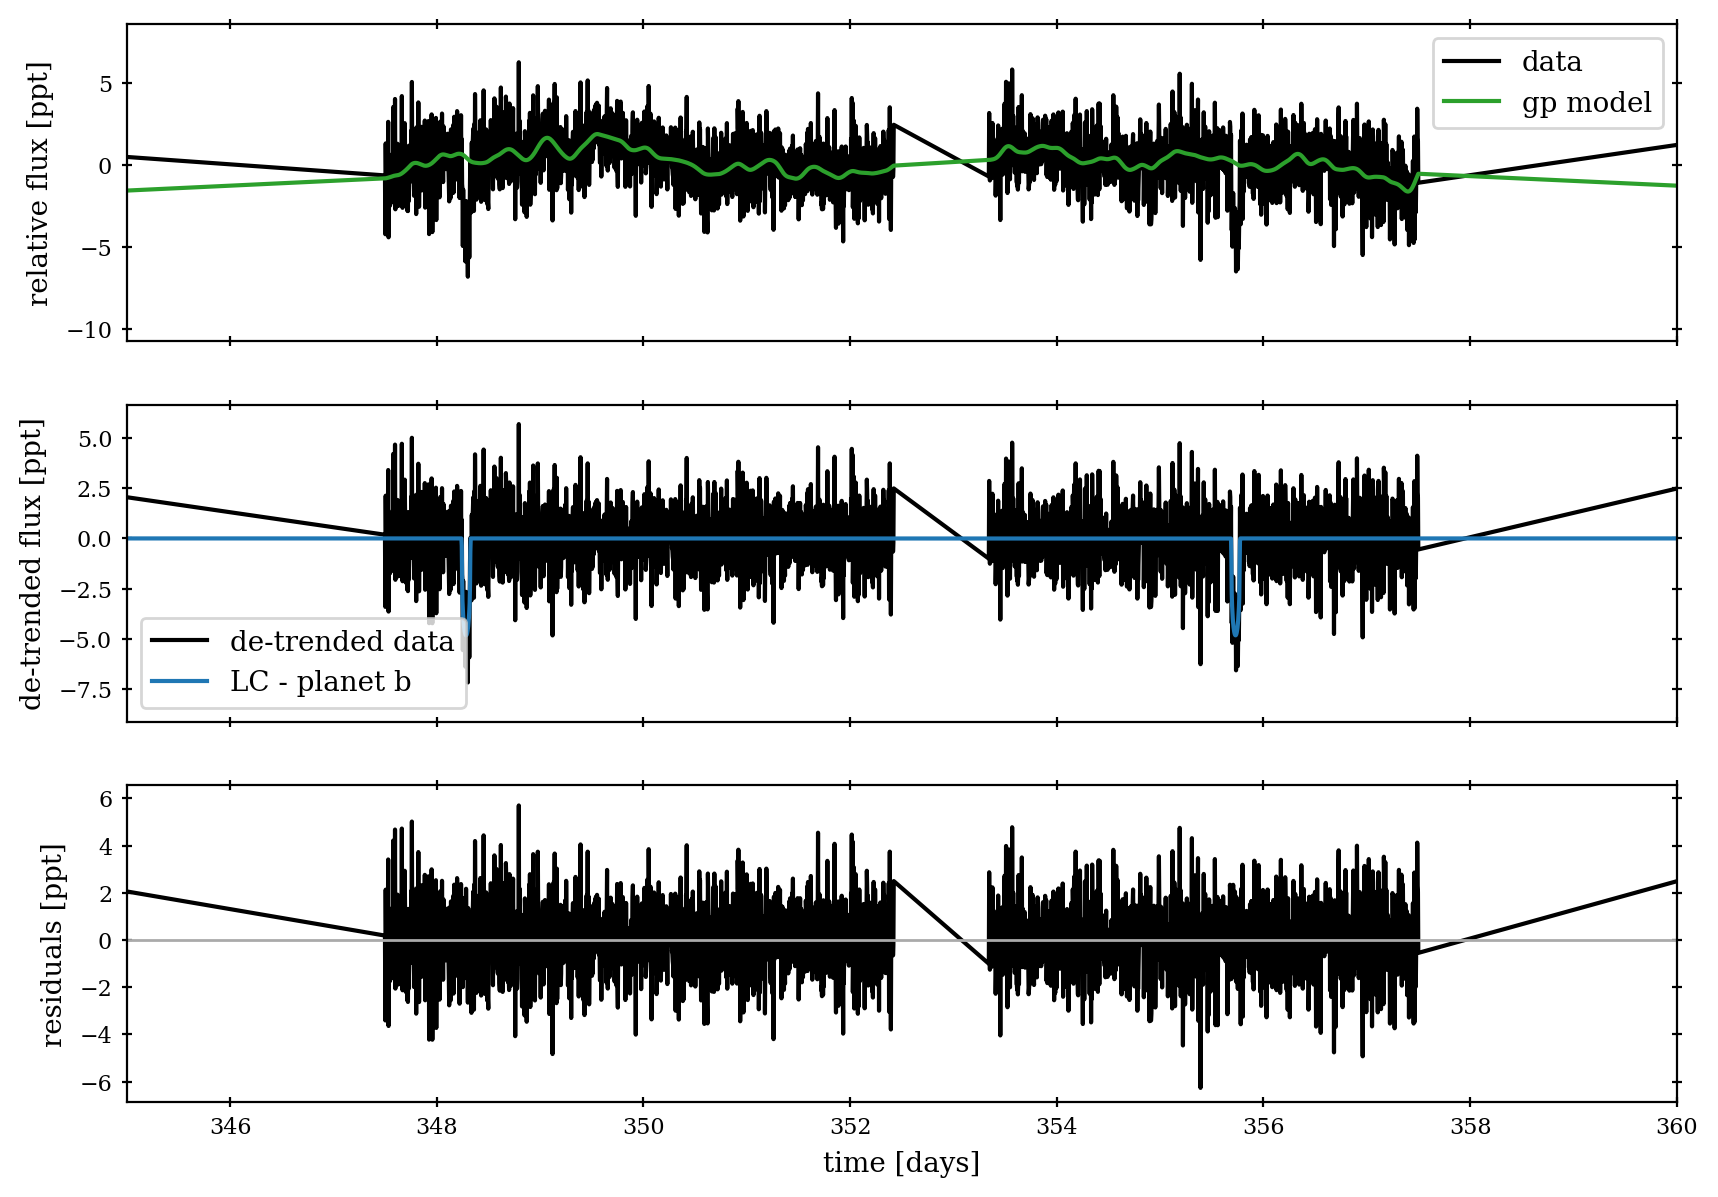

In [54]:
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

lc_mod = map_soln["light_curves"][:, 0] + map_soln["lc_mean"] # lc + mean
gp_only = map_soln["gp_lc_pred"] # gp model (on top of lc + mean)

# first plot the gp model
ax = axes[0]
ax.plot(x, y, "k", label="data")
ax.plot(x, gp_only, color="C2", label="gp model")
ax.legend(fontsize=10)
ax.set_ylabel("relative flux [ppt]")

# then detrend data for gp model and plot the lc model
ax = axes[1]
ax.plot(x, y - gp_only, "k", label="de-trended data")
ax.plot(x, lc_mod, label="LC - planet {0}".format(b))
ax.legend(fontsize=10, loc=3)
ax.set_ylabel("de-trended flux [ppt]")

# residuals of gp + lc model
ax = axes[2]
ax.plot(x, y - lc_mod - gp_only, "k")
ax.axhline(0, color="#aaaaaa", lw=1)
ax.set_ylabel("residuals [ppt]")
ax.set_xlim(x.min(), x.max())
ax.set_xlabel("time [days]")
plt.xlim(345, 360)

#plt.savefig('toi4438_lc.png', dpi=300)

#### RV map plot

In [87]:
t0

array(5.75389518)

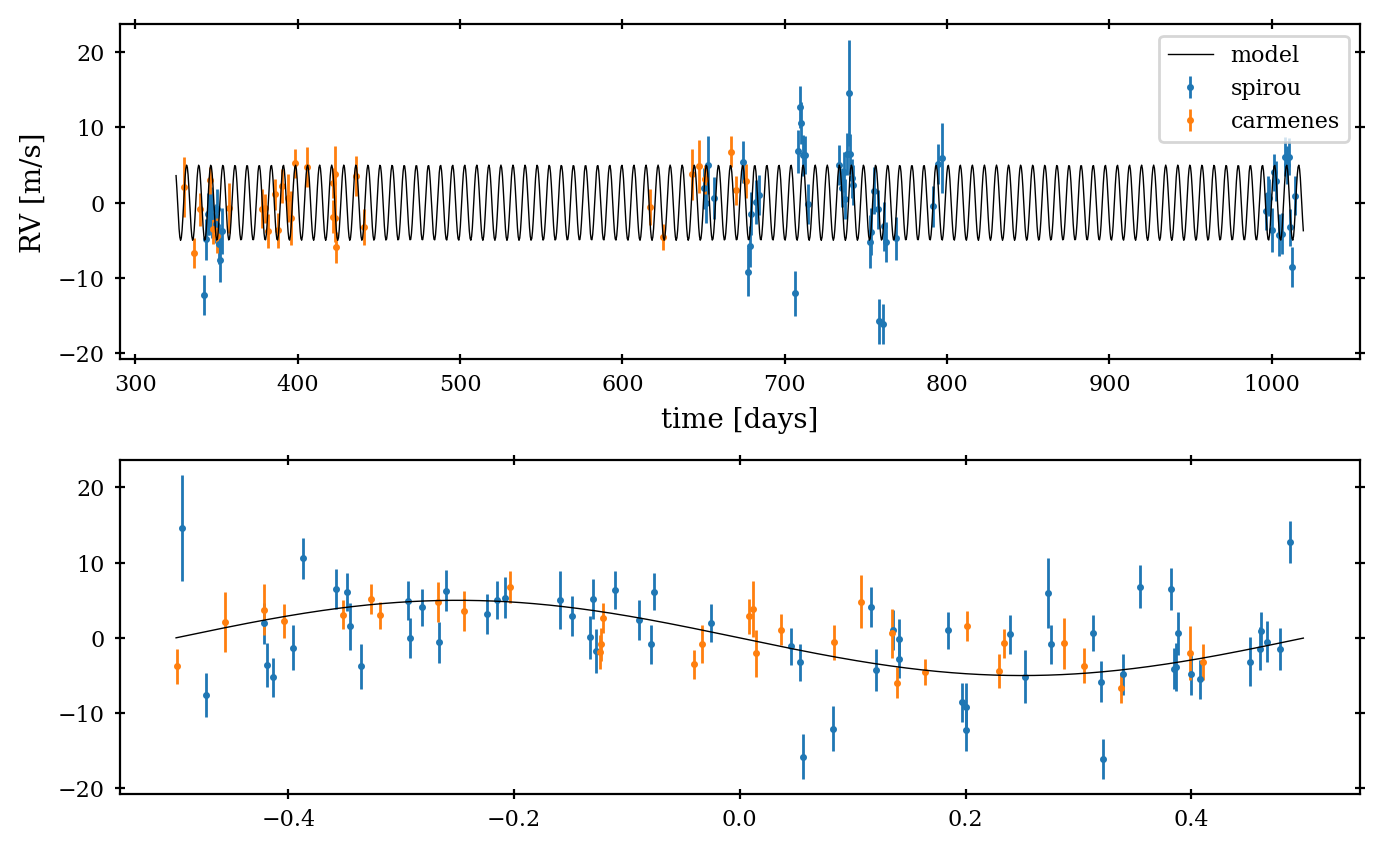

In [92]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharey=True)
fig.subplots_adjust(hspace=0.3)

for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    ax[0].errorbar(x_rv[m], y_rv[m] - map_soln["mean"][m], yerr=rv_err[m], fmt=".", 
                   elinewidth=1, markersize=3, label=name, zorder=-1000)
ax[0].plot(t_rv, map_soln["rv_model_pred"], lw=0.5, color="k", label="model")
ax[0].set_ylabel("RV [m/s]")
ax[0].set_xlabel("time [days]")
ax[0].legend(fontsize=8)

folded = (x_rv - map_soln["t0"] + 0.5 * map_soln["P"]) % map_soln["P"] - 0.5 * map_soln["P"]
inds = np.argsort(folded)
for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    xfold = (x_rv[m] - map_soln["t0"] + 0.5 * map_soln["P"]) % map_soln["P"] - 0.5 * map_soln["P"]
    inds = np.argsort(xfold)
    ax[1].errorbar(xfold[inds]/map_soln["P"], y_rv[m][inds] - map_soln["mean"][m], yerr=rv_err[m][inds], fmt=".",
                   elinewidth=1, markersize=3, label=name, zorder=-1000)
folded_t = (t_rv - map_soln["t0"] + 0.5 * map_soln["P"]) % map_soln["P"] - 0.5 * map_soln["P"]
inds2 = np.argsort(folded_t)
ax[1].plot(folded_t[inds2]/map_soln["P"], map_soln["rv_model_pred"][inds2], "k", lw=0.5)


### GP in LC, quadratic drift in RV

### Posterior Sampling

In [55]:
with model:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        initvals=map_soln,
        chains=2,
        target_accept=0.95,
        init="adapt_full",
    )

In [56]:
# # trace to save
az.to_netcdf(trace, 'trace.global4438_v1_nogp.save')

# save to trace
# trace = az.from_netcdf('trace.global4438_1.save')

In [58]:

summary = az.summary(trace, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                     var_names=[
                         "t0",
                         "P",
                         "K",
                         "b",
                         "m_pl",
                         "density_pl",
                         "a",
                         "teq",
                         "e",
                         "ror",
                         "r_pl",
                         "rstar",
                         "mstar",
                         "u_star",
                         "w",
                         "log_rho_gp",
                         "log_rho_gp_rv",
                         "log_sigma_gp",
                         "log_sigma_gp_rv",
                     ])
summary

,mean,sd,hdi_0.15%,hdi_99.85%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,5.753705,0.000647,5.751980,5.755468,0.000014,0.000010,2107.227144,1269.505246,1.002152,5.753691,0.000647
P,7.446297,0.000007,7.446277,7.446318,0.000000,0.000000,2453.241100,1077.644712,1.000417,7.446297,0.000007
K,3.449938,0.557840,1.733971,4.979335,0.011727,0.008293,2260.182201,1423.165572,1.001450,3.445236,0.557700
b,0.252532,0.169160,0.002382,0.661230,0.007590,0.005370,457.665043,723.101442,1.009567,0.232782,0.169118
e,0.080385,0.061044,0.000047,0.304299,0.002198,0.001555,775.005025,1178.589738,1.005299,0.066385,0.061029
ror,0.060383,0.001291,0.056733,0.064053,0.000040,0.000029,1023.284371,1291.263025,1.003424,0.060387,0.001291
r_pl,0.022800,0.000798,0.020505,0.025350,0.000023,0.000016,1212.313235,1339.884192,1.001439,0.022761,0.000798
rstar,0.377589,0.010521,0.345618,0.412262,0.000233,0.000165,2027.085356,1581.282116,0.999923,0.377533,0.010519
mstar,0.361947,0.019008,0.299125,0.414692,0.000410,0.000290,2185.402316,1370.474705,1.000015,0.362240,0.019004
u_star[0],0.321605,0.195390,0.000308,0.839041,0.004808,0.003401,1526.437865,1162.134329,1.002493,0.305870,0.195342


### Resulting parameters

In [59]:
import math
from uncertainties import ufloat
from uncertainties.umath import *
from asymmetric_uncertainty import a_u

params = {}
for var in list(trace.posterior.data_vars):
    parameter = a_u(trace.posterior[var].median().item(), 
             trace.posterior[var].quantile(q=0.84).item()-trace.posterior[var].median().item(), 
             trace.posterior[var].median().item()-trace.posterior[var].quantile(q=0.16).item())
    print(var, " = {r:.3f}".format(r=parameter))
    params[var] = parameter

K  = 3.445 (+0.556, -0.529)
P  = 7.446 (+0.000, -0.000)
__b_impact_parameter  = 0.220 (+0.194, -0.159)
__k_unit_disk  = -0.173 (+0.179, -0.152)
__u_star_q1  = 0.240 (+0.300, -0.133)
__u_star_q2  = 0.319 (+0.393, -0.231)
b  = 0.233 (+0.207, -0.169)
diag  = 22.686 (+7.623, -15.422)
e  = 0.066 (+0.075, -0.047)
gp_rv_pred  = -0.014 (+0.162, -0.196)
h  = 0.031 (+0.171, -0.198)
k  = -0.171 (+0.177, -0.150)
lc_mean  = -0.009 (+0.074, -0.079)
lc_pred  = 0.000 ± 0.000
logP  = 2.008 ± 0.000
log_rho_gp  = 0.781 (+0.083, -0.089)
log_rho_gp_rv  = 4.403 (+49.486, -50.390)
log_ror  = -2.807 (+0.021, -0.023)
log_sigma_gp  = -0.307 (+0.073, -0.069)
log_sigma_gp_rv  = 2.134 (+9.491, -10.315)
log_sigma_lc  = 0.348 (+0.005, -0.005)
mstar  = 0.362 (+0.019, -0.019)
r_pl  = 0.023 (+0.001, -0.001)
ror  = 0.060 (+0.001, -0.001)
rstar  = 0.378 (+0.010, -0.010)
rv_mean  = 0.338 (+4.941, -5.190)
rv_means  = 0.218 (+4.923, -5.171)
rv_model  = -0.379 (+3.219, -2.543)
rv_model_pred  = -0.026 (+2.903, -2.836)
sigmas 

In [60]:
# mass
params['K']*np.sqrt(1-params['e']**2)*(params['P']*u.day.to(u.second)*(params['mstar']*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3)*u.kg.to(u.Mearth)

### Cornerplot

In [61]:
CORNER_KWARGS = dict(
    smooth=0.5,
    plot_density=True,
    plot_datapoints=True,
    fill_contours=False,
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    levels=(0.16,0.5,0.84),
    max_n_ticks=3
)

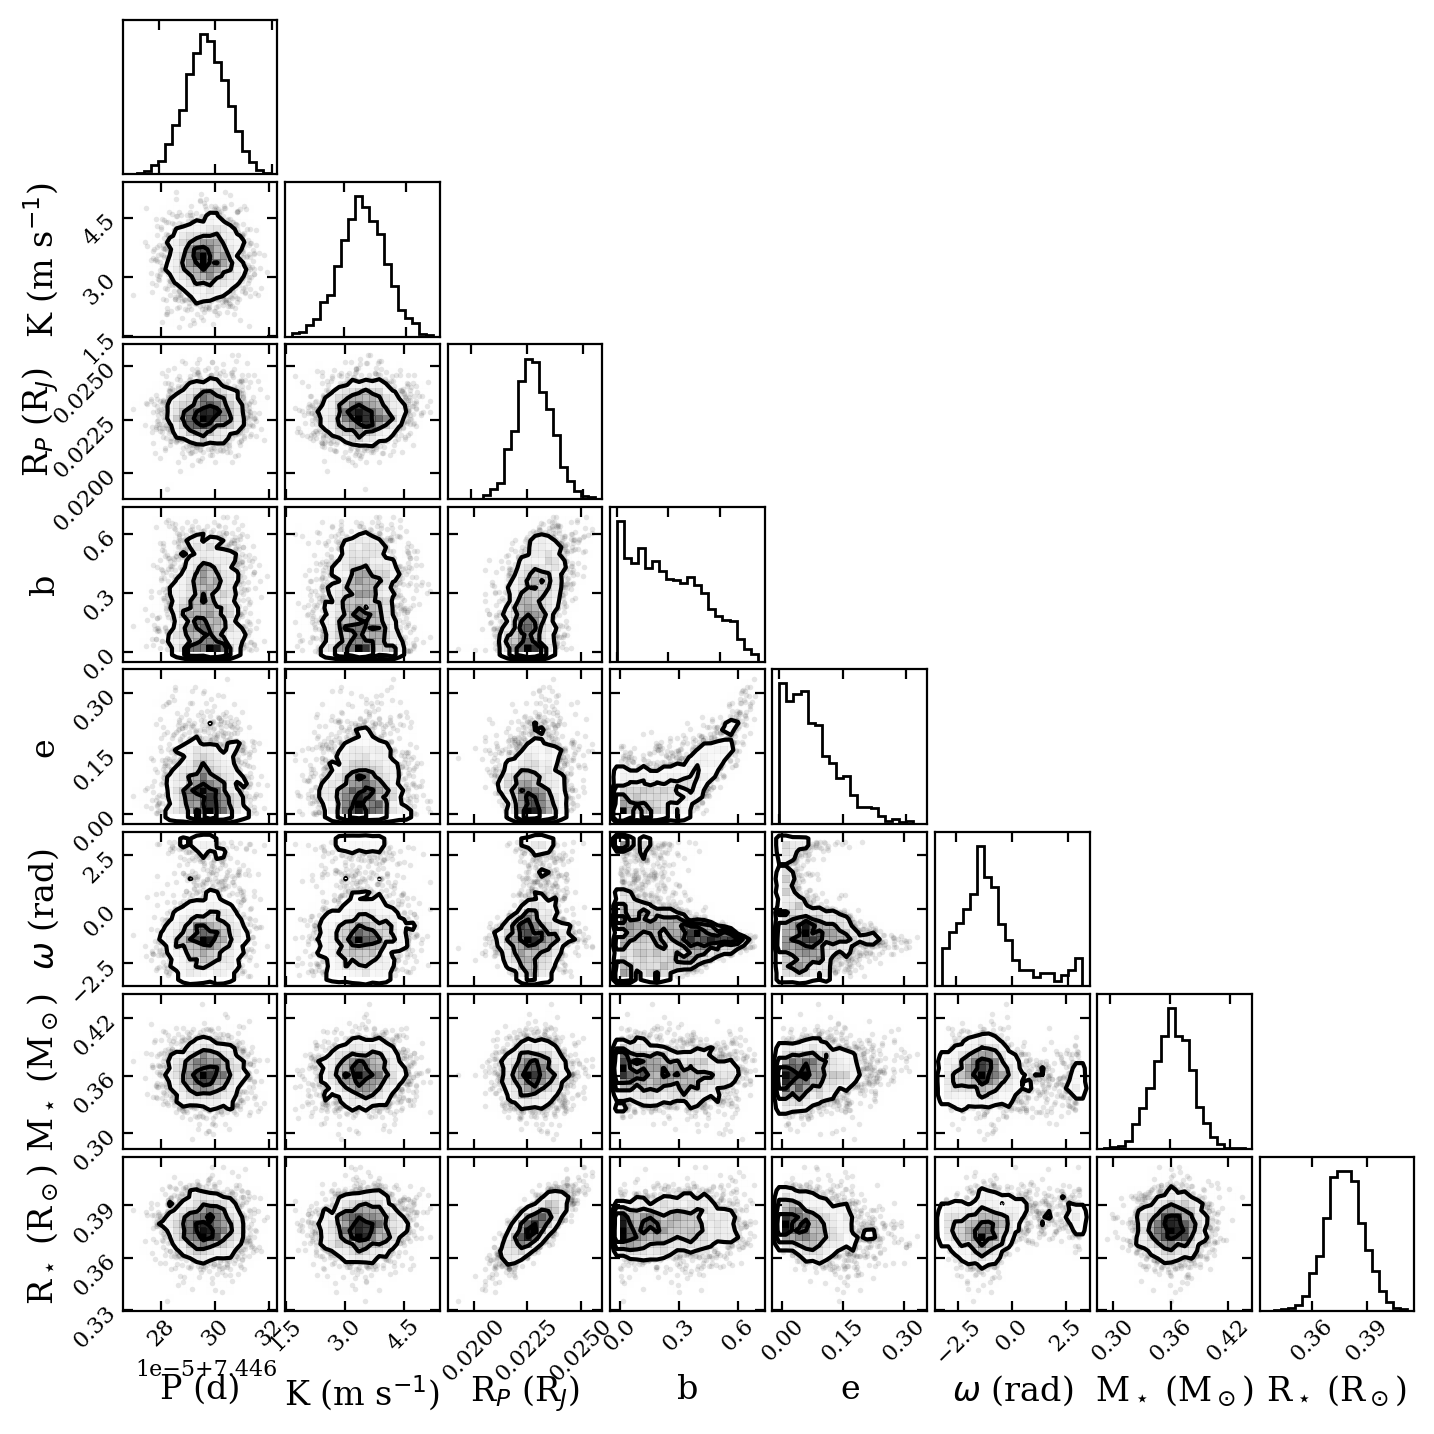

In [62]:
from cProfile import label
import corner
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter()

fig, ax = plt.subplots(8,8, figsize=(7,7))

figure = corner.corner(trace, var_names=['P', 'K', 'r_pl', 'b', 'e', 'w', 'mstar', 'rstar'],
                        labels=["P (d)", "K (m s$^{-1}$)", "R$_P$ (R$_J$)", "b", "e", "$\omega~$(rad)","M$_\star$ (M$_\odot$)","R$_\star$ (R$_\odot$)"], label_kwargs={'fontsize':12},
                        show_titles=False, title_kwargs={'fontsize':12, 'pad':9.0}, titles=['P', 'K', 'R\_P','b','e','$\omega$','M\_$\star$','R\_$\star$'], divergences=False, plot_contours=True,
                        labelpad=0.1, color='k', fig=fig, **CORNER_KWARGS)
for i,ax in enumerate(figure.get_axes()):
    ax.tick_params(axis='both', pad=1, direction='in', labelbottom=True, labelleft=True, left=True, bottom=True)
    #ax.ticklabel_format(axis='both', style='plain', scilimits=None, useOffset=None, useLocale=None, useMathText=None)
    # if i == 71 or i == 72 or i == 73:
    #     ax.xaxis.set_major_formatter(formatter)

plt.savefig('corner_toi4438.png', dpi=100, bbox_inches='tight', facecolor='w')
plt.show()

### RV fit

In [64]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

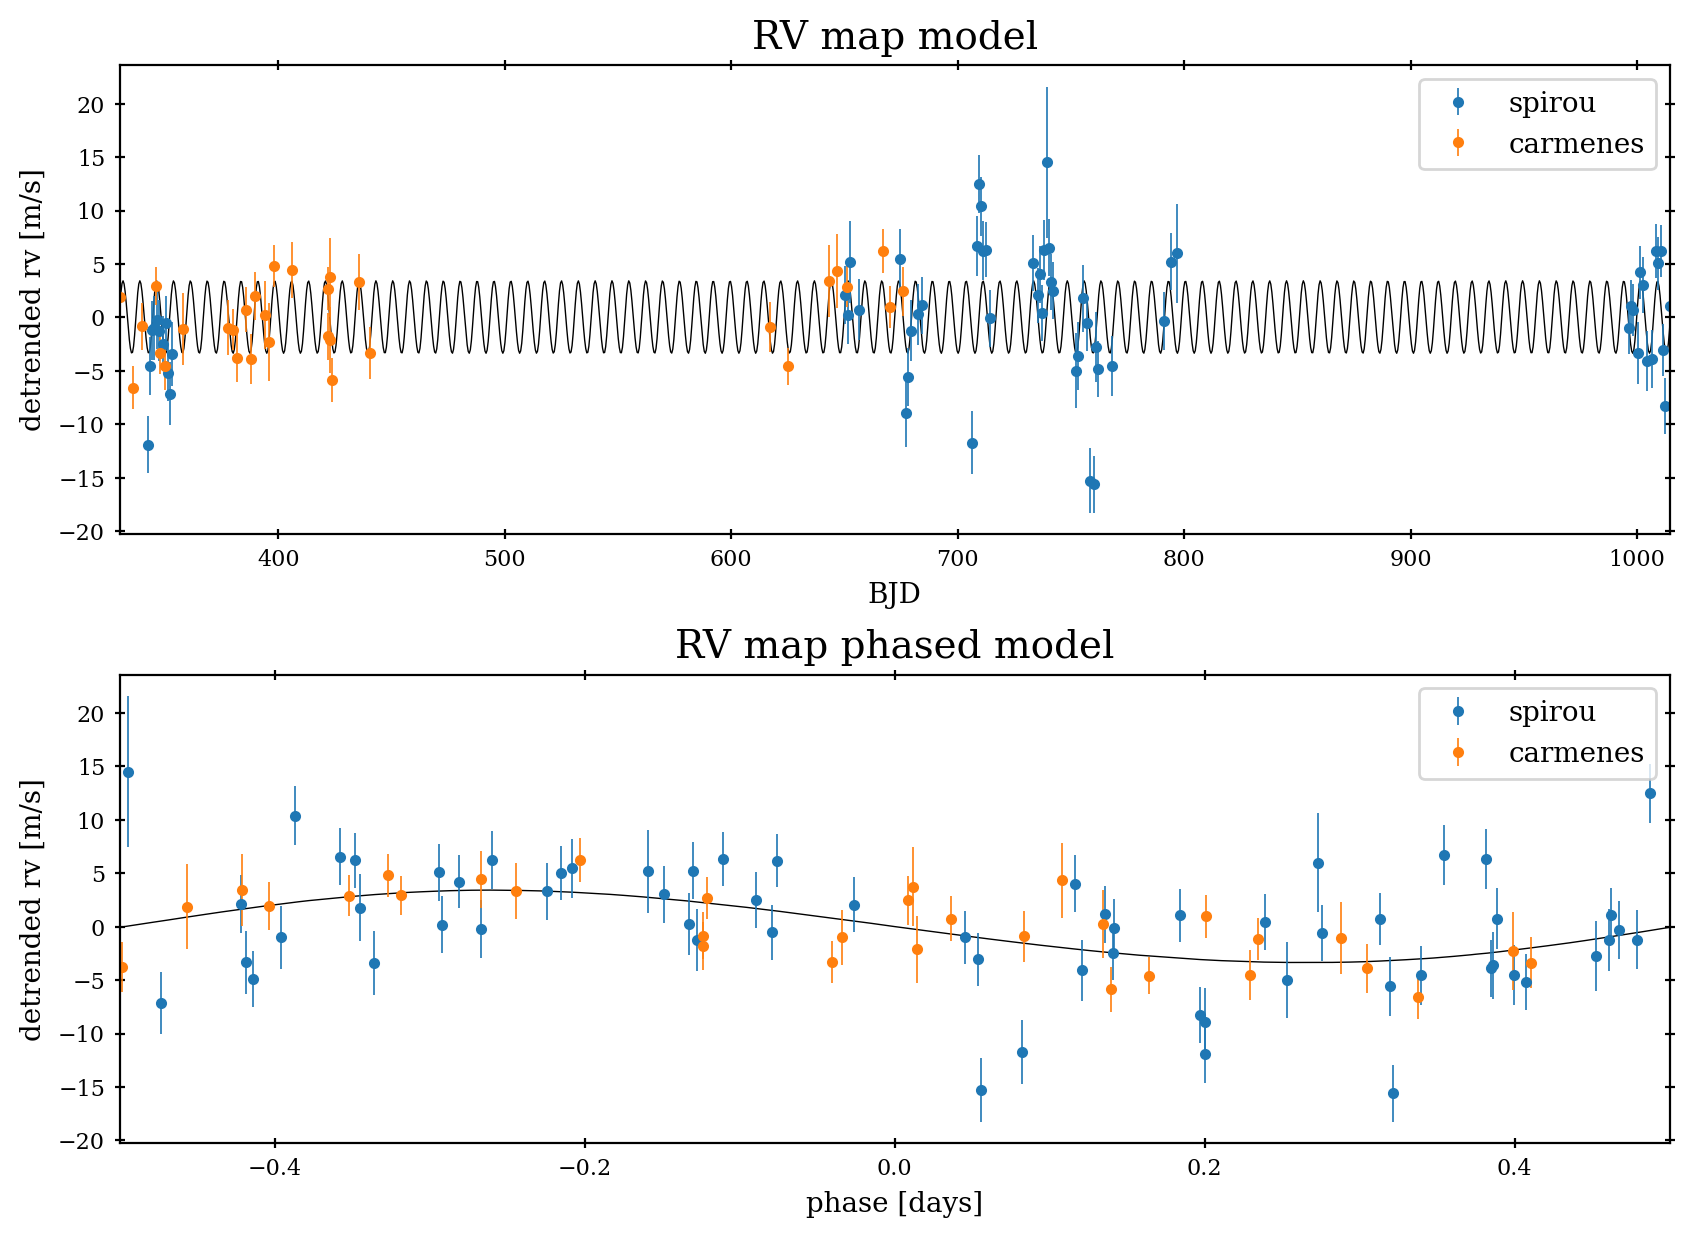

In [80]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharey=True)
fig.subplots_adjust(hspace=0.3)
period = np.median(flat_samps["P"])
t0_ = np.median(flat_samps["t0"])
rv_model_pred = np.median(flat_samps["rv_model_pred"].values, axis=-1)
rv_model_ = np.median(flat_samps['rv_model_pred'].values, axis=-1)
gp_rv_pred_ = np.median(flat_samps["gp_rv_pred"].values, axis=-1)

# # undetrended
# ax[0].plot(t_rv, rv_model_pred+gp_rv_pred_, "k", lw=0.5)
# for i, name in enumerate(rv_inst_names):
#     m = rv_inst_id == i
#     ax[0].errorbar(x_rv[m], y_rv[m], yerr=yerr_rv[m], fmt=".", label=name, elinewidth=0.6)

detrended = y_rv - gp_rv_pred_
ax[0].plot(t_rv, rv_model_pred, "k", lw=0.5)
for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    ax[0].errorbar(x_rv[m], detrended[m], yerr=yerr_rv[m], fmt=".", label=name, elinewidth=0.6)
ax[0].legend(fontsize=10)
#ax[0].errorbar(x_rv, detrended, yerr=yerr_rv, fmt=",k")
#ax[0].scatter(x_rv, detrended, c=rv_inst_id, s=8, zorder=100, cmap="tab10", vmin=0, vmax=10)
ax[0].set_xlim(x_rv.min(), x_rv.max())
ax[0].set_xlabel("BJD")
ax[0].set_ylabel("detrended rv [m/s]")
ax[0].set_title("RV map model", fontsize=14)

folded = (x_rv - t0_ + 0.5 * period) % period - 0.5 * period
inds = np.argsort(folded)
folded_t = (t_rv - t0_ + 0.5 * period) % period - 0.5 * period
inds2 = np.argsort(folded_t)
ax[1].plot(folded_t[inds2]/period, rv_model_pred[inds2], "k", lw=0.5)
for i, name in enumerate(rv_inst_names):
    m = rv_inst_id[inds] == i
    ax[1].errorbar(folded[inds][m]/period, detrended[inds][m], yerr=yerr_rv[inds][m], fmt=".", label=name, elinewidth=0.6)
ax[1].legend(fontsize=10)
#ax[1].errorbar(folded[inds]/map_soln["P"], detrended[inds], yerr=yerr_rv[inds], fmt=",k")
#ax[1].scatter(folded[inds]/map_soln["P"], detrended[inds], c=rv_inst_id[inds], s=8, zorder=100, cmap="tab10", vmin=0, vmax=10)
ax[1].set_xlim(-0.5, 0.5)
ax[1].set_xlabel("phase [days]")
ax[1].set_ylabel("detrended rv [m/s]")
ax[1].set_title("RV map phased model", fontsize=14)
plt.show()

### LC fit

### Periodogram with Residuals